# Pheno-Boundary: FTW Model Inference (FIXED)

**Run this notebook on Google Colab with GPU enabled (T4)**

This notebook:
1. Loads preprocessed FTW inputs from Google Drive
2. **Fixes band order** (BGR → RGB)
3. Downloads FTW model weights (v3.1)
4. Runs inference on GPU
5. Saves and visualizes results

---

## 0. Verify GPU Availability

In [1]:
import torch

if torch.cuda.is_available():
    print(f"✓ GPU available: {torch.cuda.get_device_name(0)}")
    print(f"  GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("⚠ No GPU detected. Go to Runtime → Change runtime type → GPU (T4)")

✓ GPU available: Tesla T4
  GPU memory: 15.8 GB


## 1. Install Dependencies

In [2]:
!pip install -q segmentation-models-pytorch timm

import numpy as np
import pickle
import os
import matplotlib.pyplot as plt

print("✓ Dependencies installed")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 899.7 kB/s eta 0:00:00
✓ Dependencies installed


## 2. Load FTW Inputs from Google Drive

In [3]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Load ftw_inputs
file_path = '/content/drive/MyDrive/pheno-boundary/data/outputs/ftw_inputs.pkl'

print("Loading preprocessed FTW inputs...")
with open(file_path, 'rb') as f:
    ftw_inputs = pickle.load(f)

print(f"\n✓ Loaded {len(ftw_inputs)} years of data:")
for year, data in ftw_inputs.items():
    print(f"  {year}: shape {data.shape}, range [{data.min():.3f}, {data.max():.3f}]")

Mounted at /content/drive
Loading preprocessed FTW inputs...

✓ Loaded 4 years of data:
  2020: shape (8, 368, 177), range [0.021, 1.000]
  2021: shape (8, 368, 177), range [0.021, 1.000]
  2022: shape (8, 368, 177), range [0.017, 1.000]
  2023: shape (8, 368, 177), range [0.020, 1.000]


## 3. **FIX: Correct Band Order**

**CRITICAL FIX:** The inputs were saved with band order **[B, G, R, NIR]**, but FTW expects **[R, G, B, NIR]**.

We need to swap Red and Blue channels for both timestamps.

In [4]:
print("Fixing band order: [B,G,R,NIR] → [R,G,B,NIR]")
print("=" * 70)

ftw_inputs_corrected = {}

for year, data in ftw_inputs.items():
    # Current order: [B, G, R, NIR, B, G, R, NIR] (channels 0-7)
    # Target order:  [R, G, B, NIR, R, G, B, NIR]
    # Reorder indices: [2, 1, 0, 3, 6, 5, 4, 7]

    corrected = data[[2, 1, 0, 3, 6, 5, 4, 7], :, :]
    ftw_inputs_corrected[year] = corrected

    print(f"{year}:")
    print(f"  Before - Ch0 (Blue):  mean={data[0].mean():.3f}")
    print(f"  After  - Ch0 (Red):   mean={corrected[0].mean():.3f}")
    print(f"  ✓ Channels corrected")

# Replace original with corrected
ftw_inputs = ftw_inputs_corrected

print("\n" + "=" * 70)
print("✓ All inputs corrected!")
print("✓ Ready for inference with correct [R,G,B,NIR] band order")

Fixing band order: [B,G,R,NIR] → [R,G,B,NIR]
2020:
  Before - Ch0 (Blue):  mean=0.153
  After  - Ch0 (Red):   mean=0.193
  ✓ Channels corrected
2021:
  Before - Ch0 (Blue):  mean=0.116
  After  - Ch0 (Red):   mean=0.185
  ✓ Channels corrected
2022:
  Before - Ch0 (Blue):  mean=0.105
  After  - Ch0 (Red):   mean=0.161
  ✓ Channels corrected
2023:
  Before - Ch0 (Blue):  mean=0.134
  After  - Ch0 (Red):   mean=0.177
  ✓ Channels corrected

✓ All inputs corrected!
✓ Ready for inference with correct [R,G,B,NIR] band order


## 4. Download FTW Model Weights

In [5]:
import urllib.request

model_dir = "models"
os.makedirs(model_dir, exist_ok=True)

model_url = "https://github.com/fieldsoftheworld/ftw-baselines/releases/download/v3.1/prue_efnetb3_ccby_checkpoint.ckpt"
model_path = os.path.join(model_dir, "prue_efnetb3_ccby_checkpoint.ckpt")

if not os.path.exists(model_path):
    print("Downloading FTW model weights (~50 MB)...")
    urllib.request.urlretrieve(model_url, model_path)
    print(f"✓ Downloaded to {model_path}")
else:
    print(f"✓ Model already exists: {model_path}")

✓ Downloaded to models/prue_efnetb3_ccby_checkpoint.ckpt


## 5. Load FTW Model

In [6]:
import segmentation_models_pytorch as smp

class FTWInference:
    """FTW model wrapper for field boundary segmentation."""

    def __init__(self, checkpoint_path, device='cuda'):
        self.device = torch.device(device)

        # Create U-Net with EfficientNet-B3 encoder
        self.model = smp.Unet(
            encoder_name="efficientnet-b3",
            encoder_weights=None,
            in_channels=8,  # Bi-temporal RGB+NIR
            classes=3,      # Non-field, Field, Boundary
        )

        # Load checkpoint
        checkpoint = torch.load(checkpoint_path, map_location=self.device)
        state_dict = checkpoint.get('state_dict', checkpoint)

        # Remove 'model.' prefix from keys
        state_dict = {k.replace('model.', ''): v for k, v in state_dict.items()}

        # Load weights (strict=True to catch any issues)
        self.model.load_state_dict(state_dict, strict=True)
        self.model.to(self.device)
        self.model.eval()

        print(f"✓ Model loaded on {self.device}")
        print(f"  Total parameters: {sum(p.numel() for p in self.model.parameters()):,}")

    def predict(self, input_array):
        """Run inference on 8-channel input."""
        input_tensor = torch.from_numpy(input_array).unsqueeze(0).to(self.device)

        with torch.no_grad():
            logits = self.model(input_tensor)
            probs = torch.softmax(logits, dim=1).cpu().numpy()[0]

        return {
            'field_prob': probs[1],      # Class 1: Field interior
            'boundary_prob': probs[2],   # Class 2: Boundary
            'class_map': np.argmax(probs, axis=0),
            'field_mask': probs[1] > 0.5,
            'raw_probs': probs,
        }

# Initialize model
ftw_model = FTWInference(model_path, device='cuda')

✓ Model loaded on cuda
  Total parameters: 13,161,123


## 6. Run Inference on All Years

In [7]:
print("Running inference...")
print("=" * 70)

ftw_results = {}

for year in sorted(ftw_inputs.keys()):
    print(f"\n{year}:", end=" ")

    # Run inference
    results = ftw_model.predict(ftw_inputs[year])
    ftw_results[year] = results

    # Print statistics
    field_pct = 100 * results['field_mask'].sum() / results['field_mask'].size
    mean_prob = results['field_prob'].mean()
    max_prob = results['field_prob'].max()

    print(f"Field coverage: {field_pct:.1f}%")
    print(f"  Mean field probability: {mean_prob:.3f}")
    print(f"  Max field probability:  {max_prob:.3f}")

print("\n" + "=" * 70)
print(f"✓ Inference complete for {len(ftw_results)} years!")

Running inference...

2020: Field coverage: 52.5%
  Mean field probability: 0.524
  Max field probability:  1.000

2021: Field coverage: 55.0%
  Mean field probability: 0.550
  Max field probability:  1.000

2022: Field coverage: 55.0%
  Mean field probability: 0.549
  Max field probability:  1.000

2023: Field coverage: 51.5%
  Mean field probability: 0.515
  Max field probability:  1.000

✓ Inference complete for 4 years!


## 7. Save Results

In [8]:
from google.colab import files

# Save results
output_path = 'ftw_results_FIXED.pkl'
with open(output_path, 'wb') as f:
    pickle.dump(ftw_results, f)

print(f"✓ Results saved to {output_path}")
print(f"  File size: {os.path.getsize(output_path) / (1024**2):.1f} MB")

# Download to local machine
files.download(output_path)
print("\n✓ Download started. Save this file to continue analysis locally.")

✓ Results saved to ftw_results_FIXED.pkl
  File size: 7.2 MB


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✓ Download started. Save this file to continue analysis locally.


## 8. Visualize Results - Overview

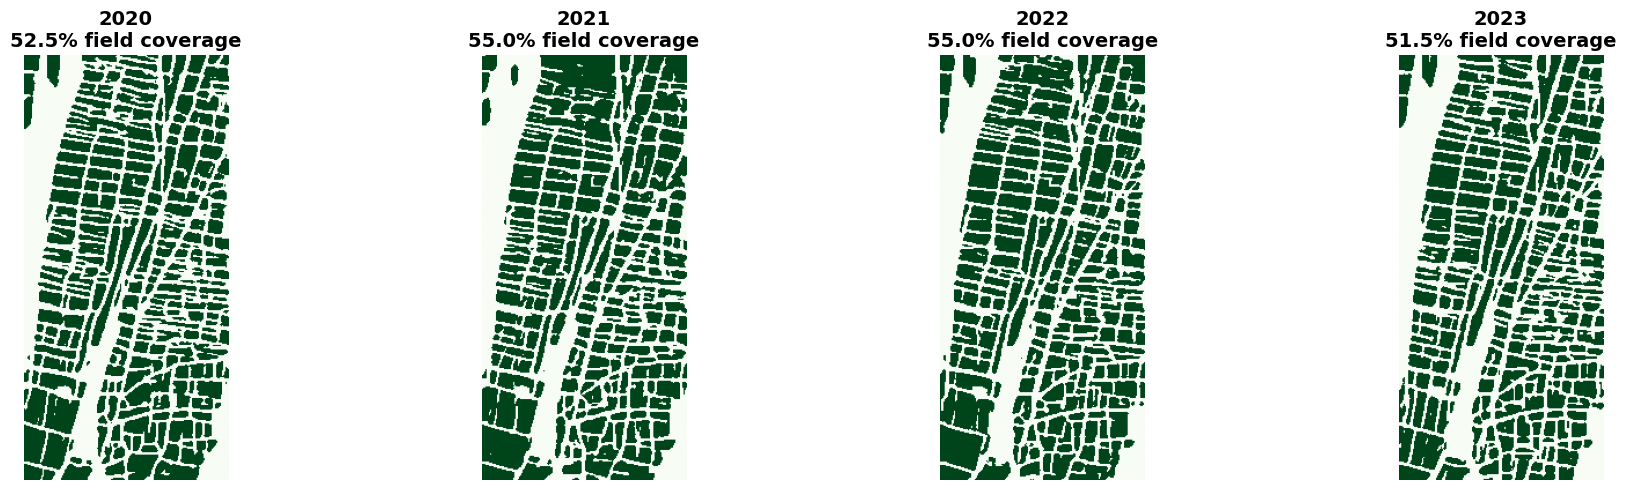

✓ Field masks for all years


In [9]:
# Plot field masks for all years
fig, axes = plt.subplots(1, len(ftw_results), figsize=(5*len(ftw_results), 5))
if len(ftw_results) == 1:
    axes = [axes]

for idx, year in enumerate(sorted(ftw_results.keys())):
    axes[idx].imshow(ftw_results[year]['field_mask'], cmap='Greens')
    field_pct = 100 * ftw_results[year]['field_mask'].sum() / ftw_results[year]['field_mask'].size
    axes[idx].set_title(f'{year}\n{field_pct:.1f}% field coverage', fontsize=14, fontweight='bold')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print("✓ Field masks for all years")

## 9. Visualize Results - Detailed View (Best Year)

Showing detailed view for 2021 (highest detection)



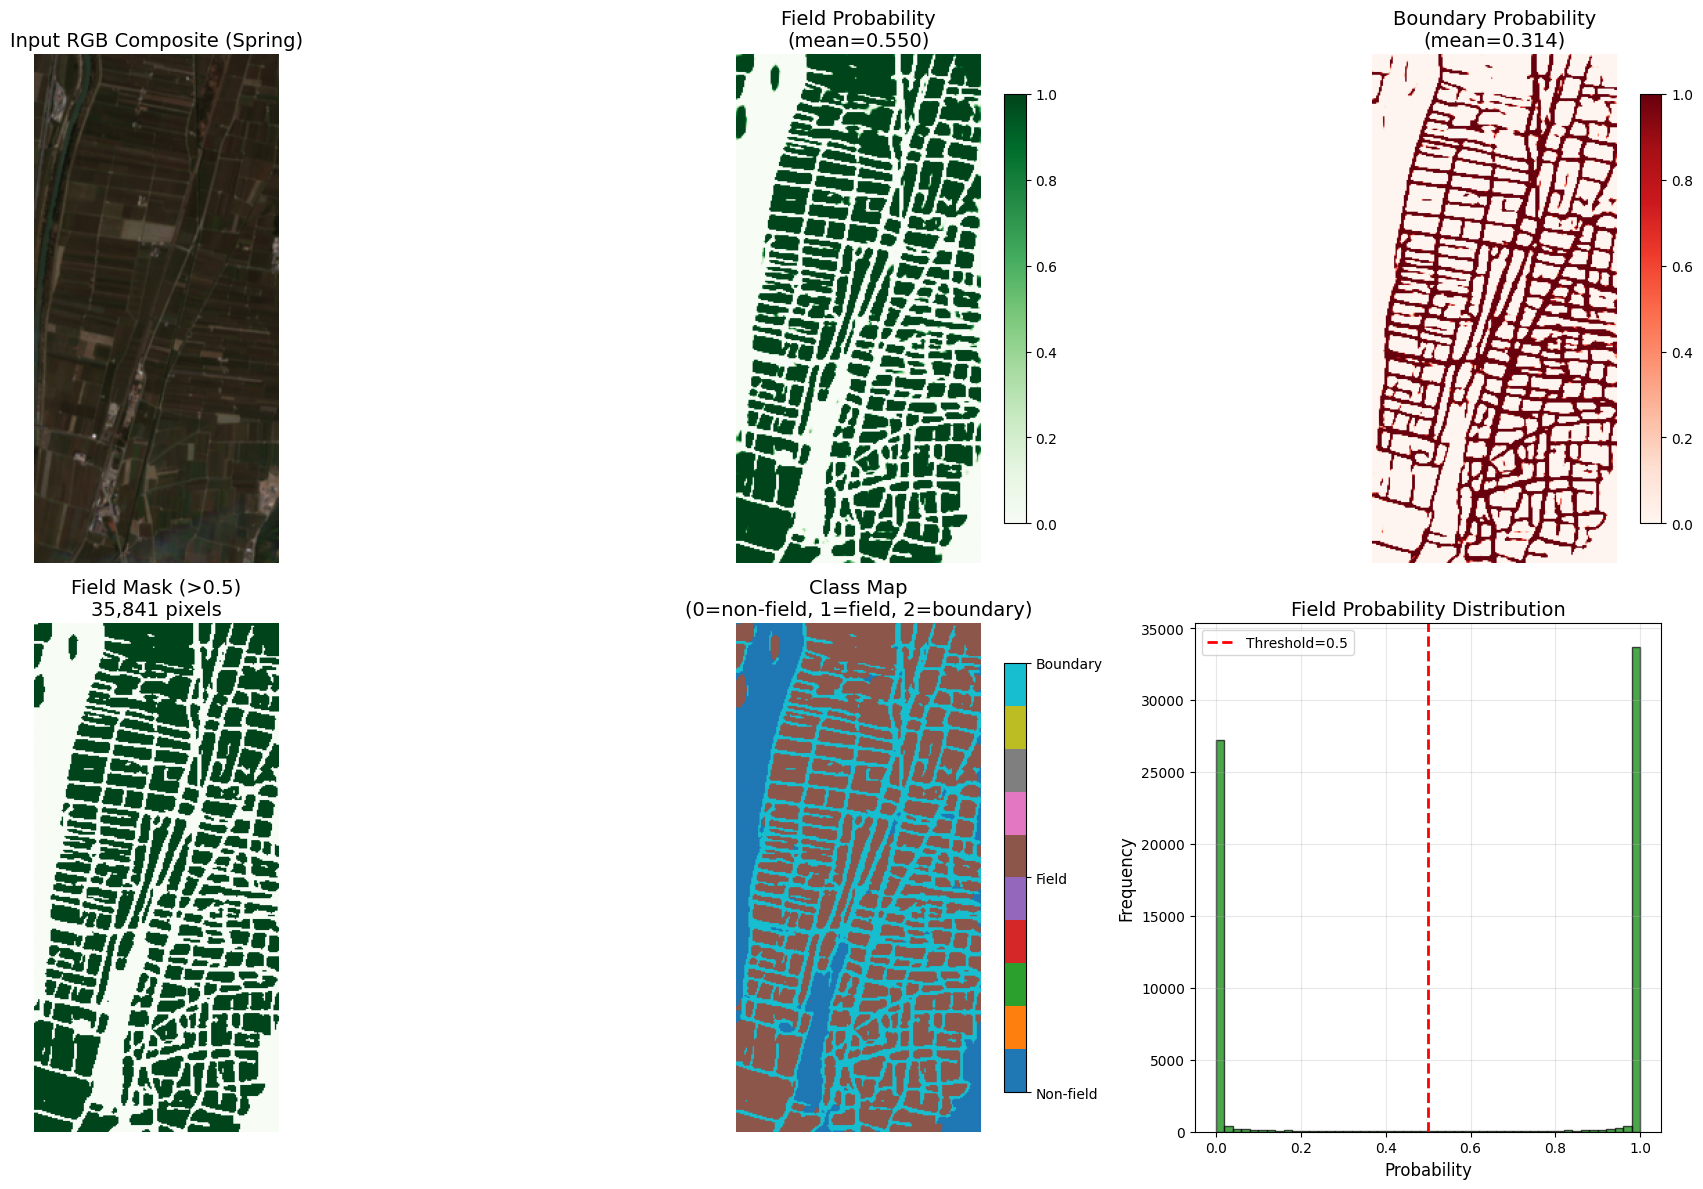


✓ Detailed visualization for 2021


In [10]:
# Find year with highest field detection
best_year = max(ftw_results.keys(),
                key=lambda y: ftw_results[y]['field_mask'].sum())

print(f"Showing detailed view for {best_year} (highest detection)\n")

results = ftw_results[best_year]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# RGB composite (corrected order)
rgb = ftw_inputs[best_year][[0, 1, 2], :, :]  # Now R, G, B (corrected!)
rgb_vis = np.transpose(rgb, (1, 2, 0))
axes[0, 0].imshow(rgb_vis)
axes[0, 0].set_title('Input RGB Composite (Spring)', fontsize=14)
axes[0, 0].axis('off')

# Field probability
im1 = axes[0, 1].imshow(results['field_prob'], cmap='Greens', vmin=0, vmax=1)
axes[0, 1].set_title(f"Field Probability\n(mean={results['field_prob'].mean():.3f})", fontsize=14)
axes[0, 1].axis('off')
plt.colorbar(im1, ax=axes[0, 1], fraction=0.046)

# Boundary probability
im2 = axes[0, 2].imshow(results['boundary_prob'], cmap='Reds', vmin=0, vmax=1)
axes[0, 2].set_title(f"Boundary Probability\n(mean={results['boundary_prob'].mean():.3f})", fontsize=14)
axes[0, 2].axis('off')
plt.colorbar(im2, ax=axes[0, 2], fraction=0.046)

# Field mask
axes[1, 0].imshow(results['field_mask'], cmap='Greens')
n_field = results['field_mask'].sum()
axes[1, 0].set_title(f"Field Mask (>0.5)\n{n_field:,} pixels", fontsize=14)
axes[1, 0].axis('off')

# Class map
im3 = axes[1, 1].imshow(results['class_map'], cmap='tab10', vmin=0, vmax=2)
axes[1, 1].set_title('Class Map\n(0=non-field, 1=field, 2=boundary)', fontsize=14)
axes[1, 1].axis('off')
cbar = plt.colorbar(im3, ax=axes[1, 1], ticks=[0, 1, 2], fraction=0.046)
cbar.set_ticklabels(['Non-field', 'Field', 'Boundary'])

# Probability histogram
axes[1, 2].hist(results['field_prob'].flatten(), bins=50, alpha=0.7, color='green', edgecolor='black')
axes[1, 2].set_title('Field Probability Distribution', fontsize=14)
axes[1, 2].set_xlabel('Probability', fontsize=12)
axes[1, 2].set_ylabel('Frequency', fontsize=12)
axes[1, 2].axvline(0.5, color='red', linestyle='--', linewidth=2, label='Threshold=0.5')
axes[1, 2].legend(fontsize=10)
axes[1, 2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ Detailed visualization for {best_year}")

---

## Summary

**What was fixed:**
- ✅ Band order corrected: [B,G,R,NIR] → [R,G,B,NIR]
- ✅ Model loading with `strict=True` (validates all weights)
- ✅ Proper visualization with corrected channels

**Next steps:**
1. Download `ftw_results_FIXED.pkl` to your local machine
2. Continue with stability analysis in the main pipeline notebook
3. Compute IoU between years and detect changes